In [1]:
# Import necessary modules
import numpy as np 
import pandas as pd 
import seaborn as sb
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# 1. Explanatory Data Analysis

In [2]:
df = pd.read_csv('/kaggle/input/credit-card-transactions/credit_card_transactions-ibm_v2.csv')

In [3]:
df.shape

(24386900, 15)

In [4]:
# 10% of data and shuffle the data
subset_size = int(0.1 * len(df))  
df = df.sample(frac=1, random_state=42)  
subset_df = df.head(subset_size)

In [5]:
subset_df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
18199893,1470,0,2019,7,10,00:11,$59.18,Chip Transaction,-6853385250336487907,Harwood,MD,20776.0,5813,NaN,No
9731325,822,1,2019,1,14,22:12,$280.91,Online Transaction,4241336128694185533,ONLINE,NaN,NaN,4814,NaN,No
536687,41,3,2010,3,15,07:07,$-144.00,Swipe Transaction,190253443608377572,Hemet,CA,92543.0,3359,NaN,No
13223840,1084,0,2015,9,20,14:58,$6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,NaN,No
17070521,1384,0,2014,10,12,11:44,$9.17,Swipe Transaction,-5023497618971072366,Gardner,KS,66030.0,5812,NaN,No


In [6]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2438690 entries, 18199893 to 23041253
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 297.7+ MB


In [7]:
subset_df.head(10)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
18199893,1470,0,2019,7,10,00:11,$59.18,Chip Transaction,-6853385250336487907,Harwood,MD,20776.0,5813,NaN,No
9731325,822,1,2019,1,14,22:12,$280.91,Online Transaction,4241336128694185533,ONLINE,NaN,NaN,4814,NaN,No
536687,41,3,2010,3,15,07:07,$-144.00,Swipe Transaction,190253443608377572,Hemet,CA,92543.0,3359,NaN,No
13223840,1084,0,2015,9,20,14:58,$6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,NaN,No
17070521,1384,0,2014,10,12,11:44,$9.17,Swipe Transaction,-5023497618971072366,Gardner,KS,66030.0,5812,NaN,No
792843,55,3,2006,6,10,09:15,$1.36,Swipe Transaction,-6571010470072147219,Rego Park,NY,11374.0,5499,NaN,No
8966297,776,0,2007,2,25,22:31,$97.81,Swipe Transaction,-6974082828836151610,Milwaukee,WI,53224.0,4900,NaN,No
895801,66,0,2007,8,21,13:02,$23.25,Swipe Transaction,3675785629314646441,Gonzales,TX,78629.0,7349,NaN,No
22902727,1880,2,2010,12,31,01:06,$486.70,Swipe Transaction,-3398248499422470718,Atlantic City,NJ,8401.0,7995,NaN,No
5845532,490,5,2015,11,28,13:45,$92.67,Chip Transaction,4722913068560264812,Pompano Beach,FL,33063.0,5411,NaN,No


### 1.2 Data Cleaning, Encoding, and Feature  Engineering
1. strip the '$' from the Amount and Credit Limit
2. create hour and minute variables by extracting from 'Time'
3. change categorical variable to binary variable
4. missing value

In [8]:
# Check the number of fraudulent transactions
subset_df['Is Fraud?'].value_counts()

Is Fraud?
No     2435655
Yes       3035
Name: count, dtype: int64

In [9]:
# We need to strip the '$' from the Amount to cast as a float
subset_df["Amount"]=subset_df["Amount"].str.replace("$","").astype(float)

In [10]:
subset_df.Time.head(5)

18199893    00:11
9731325     22:12
536687      07:07
13223840    14:58
17070521    11:44
Name: Time, dtype: object

In [11]:
# Extract the hour and minute to perform a more refined time series analysis
subset_df["Hour"] = subset_df["Time"].str [0:2]
subset_df["Minute"] = subset_df["Time"].str [3:5]
subset_df = subset_df.drop(['Time'],axis=1)

In [12]:
subset_df.shape

(2438690, 16)

In [13]:
# change the is fraud column to binary 
subset_df["Is Fraud?"] = subset_df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [14]:
subset_df.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?', 'Hour', 'Minute'],
      dtype='object')

In [15]:
# Fill missing values
subset_df['Merchant State'].fillna('No State', inplace=True)
subset_df['Zip'].fillna(0, inplace=True)
subset_df['Errors?'].fillna('No Error', inplace=True)

In [16]:
subset_df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
18199893,1470,0,2019,7,10,59.18,Chip Transaction,-6853385250336487907,Harwood,MD,20776.0,5813,No Error,0,00,11
9731325,822,1,2019,1,14,280.91,Online Transaction,4241336128694185533,ONLINE,No State,0.0,4814,No Error,0,22,12
536687,41,3,2010,3,15,-144.00,Swipe Transaction,190253443608377572,Hemet,CA,92543.0,3359,No Error,0,07,07
13223840,1084,0,2015,9,20,6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,No Error,0,14,58
17070521,1384,0,2014,10,12,9.17,Swipe Transaction,-5023497618971072366,Gardner,KS,66030.0,5812,No Error,0,11,44


### 1.3 Visualization

In [17]:
fraud_data = subset_df[subset_df['Is Fraud?'] == 1]

### （1）Distribution of Fraudulent Transaction Amount

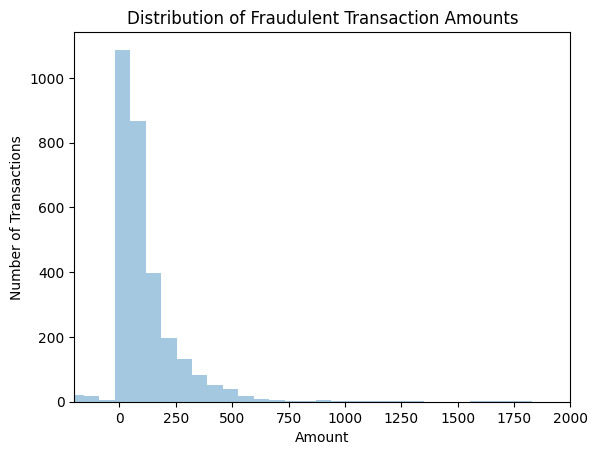

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(fraud_data['Amount'].astype(float), kde=False, bins=80)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim(-200, 2000)
plt.show()

### (3) Transaction amount by fraud

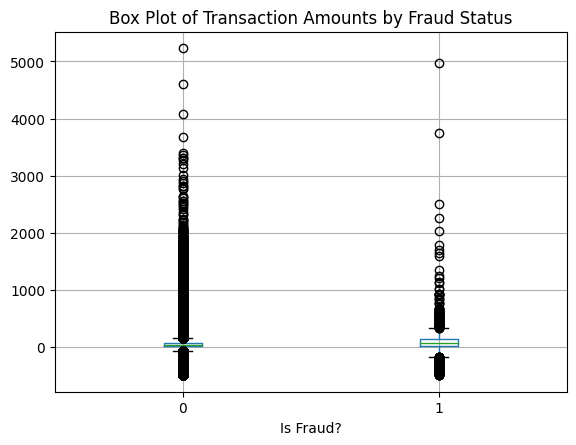

In [19]:
#transaction amount by fraud
subset_df.boxplot(column='Amount', by='Is Fraud?')
plt.title('Box Plot of Transaction Amounts by Fraud Status')
plt.suptitle('')
plt.show()

### (4)Time - by year

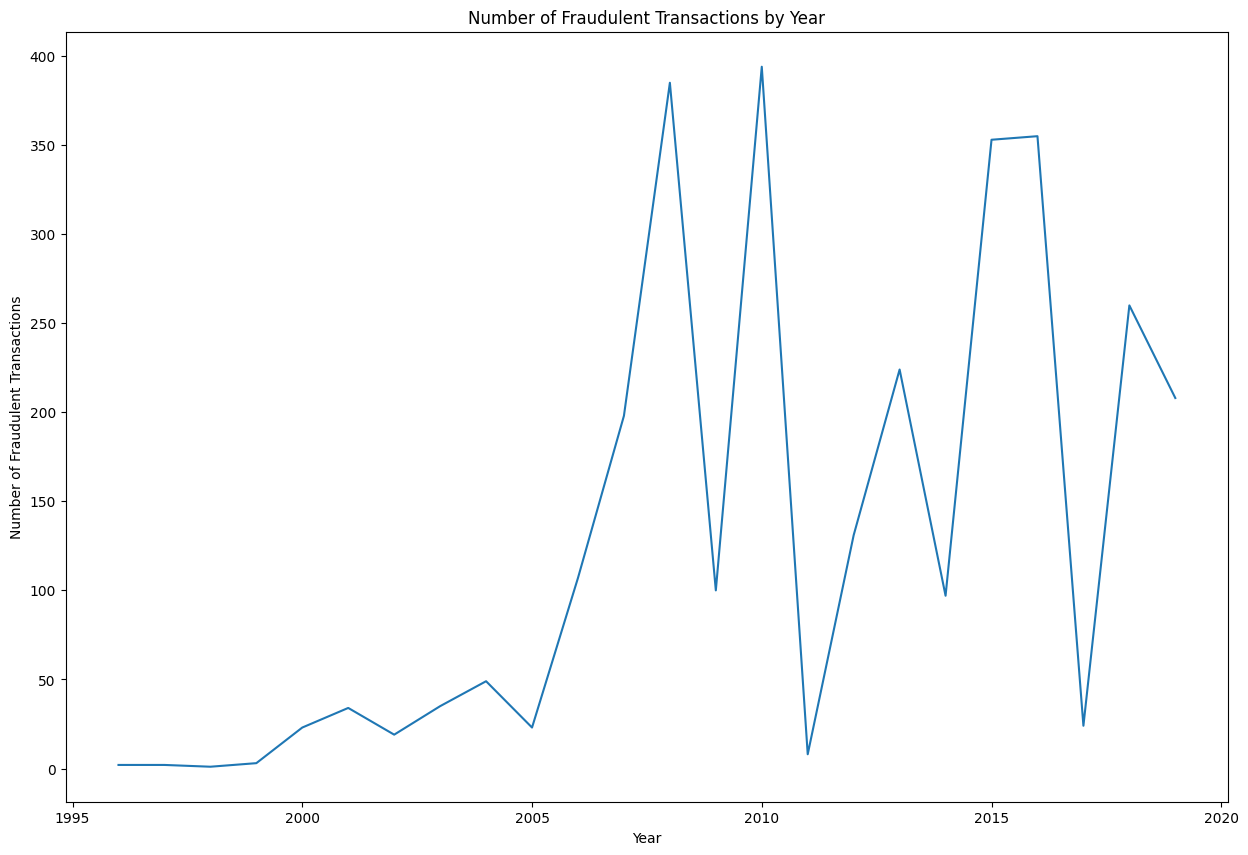

In [20]:
fraud_counts_per_year = subset_df[subset_df['Is Fraud?'] == 1].groupby('Year').size()

# Now create the line plot with the aggregated data
plt.figure(figsize=(15, 10))
sns.lineplot(data=fraud_counts_per_year)
plt.title('Number of Fraudulent Transactions by Year')
plt.xlabel('Year')  # Optional: it's good practice to label your axes
plt.ylabel('Number of Fraudulent Transactions')  # Optional: label for y-axis
plt.show()

### - by date

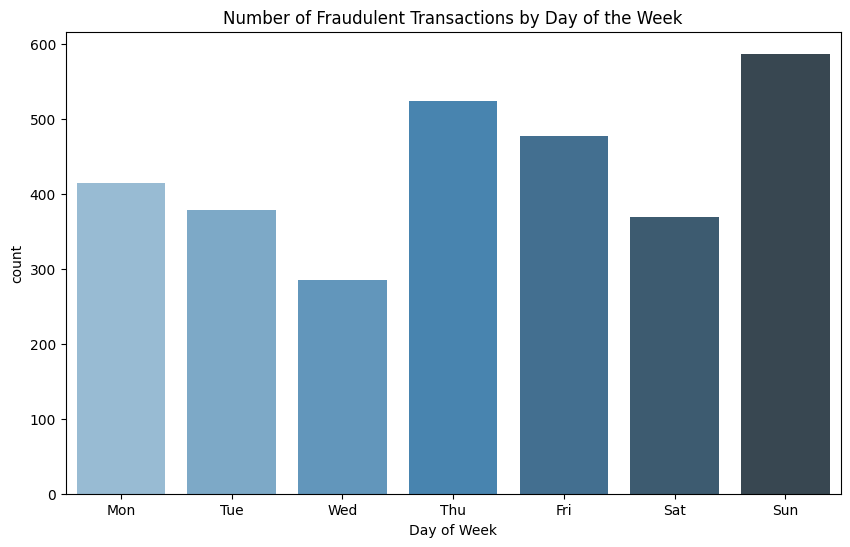

In [21]:
subset_df['Date'] = pd.to_datetime(subset_df[['Year', 'Month', 'Day']])

# Extract day of the week and map it to its name
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
subset_df['Day of Week'] = subset_df['Date'].dt.dayofweek.map(days)

fraud_data = subset_df[subset_df['Is Fraud?'] == 1]

# Visualize
plt.figure(figsize=(10, 6))
sns.countplot(data=fraud_data, x='Day of Week', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], palette="Blues_d")
plt.title('Number of Fraudulent Transactions by Day of the Week')
plt.show()

### - by months

In [22]:
# Distribution of transactions over months
fig = px.histogram(fraud_data, x="Month")
fig.update_layout(bargap=0.2, title="Transactions Distribution over Months")
fig.show()

### - by hours

In [23]:
# Distribution of transactions over hours in a day
fig_hour = px.histogram(fraud_data, x="Hour")
fig.update_layout(bargap=0.09, title="Transactions Distribution over Hour")
fig_hour.show()

### (5) Transaction Method

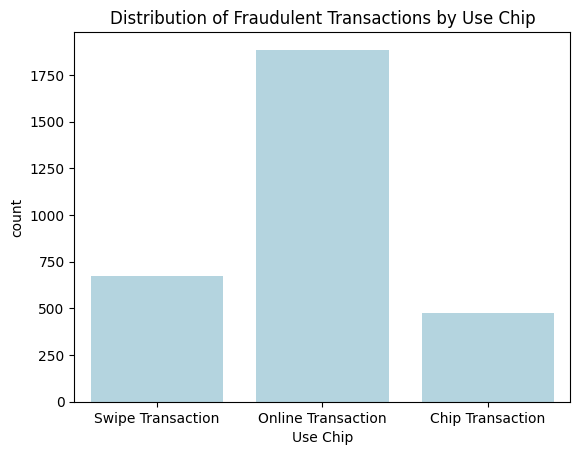

In [24]:
sns.countplot(data=fraud_data, x='Use Chip', color='lightblue')
plt.title('Distribution of Fraudulent Transactions by Use Chip')
plt.show()

### 1.3 Data Transformation

In [25]:
subset_df.head()


,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute,Date,Day of Week
18199893,1470,0,2019,7,10,59.18,Chip Transaction,-6853385250336487907,Harwood,MD,20776.0,5813,No Error,0,00,11,2019-07-10,Wed
9731325,822,1,2019,1,14,280.91,Online Transaction,4241336128694185533,ONLINE,No State,0.0,4814,No Error,0,22,12,2019-01-14,Mon
536687,41,3,2010,3,15,-144.00,Swipe Transaction,190253443608377572,Hemet,CA,92543.0,3359,No Error,0,07,07,2010-03-15,Mon
13223840,1084,0,2015,9,20,6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,No Error,0,14,58,2015-09-20,Sun
17070521,1384,0,2014,10,12,9.17,Swipe Transaction,-5023497618971072366,Gardner,KS,66030.0,5812,No Error,0,11,44,2014-10-12,Sun


### drop feature

1. user / card / date / day of week

In [26]:
subset_df = subset_df.drop(columns=["Day of Week", "User", "Date", "Card"])

In [27]:
import category_encoders as ce

categorical_cols = ["Use Chip", "Merchant City", "Merchant State", "Errors?"]

# Creating a dictionary to store the target encoding mappings
target_encoding_map = {}

for col in categorical_cols:
    # Calculating the mean target variable for each category
    encoding = subset_df.groupby(col)["Is Fraud?"].mean().to_dict()
    
    # Map the encoding to the column
    subset_df[col + "_target_encoded"] = subset_df[col].map(encoding)
    
    # Store the encoding mapping for later use
    target_encoding_map[col] = encoding

# Drop the original categorical columns
subset_df.drop(columns=categorical_cols, inplace=True)


In [28]:
df_transformed = subset_df
df_transformed.head()

,Year,Month,Day,Amount,Merchant Name,Zip,MCC,Is Fraud?,Hour,Minute,Use Chip_target_encoded,Merchant City_target_encoded,Merchant State_target_encoded,Errors?_target_encoded
18199893,2019,7,10,59.18,-6853385250336487907,20776.0,5813,0,00,11,0.000760,0.000000,0.000264,0.001216
9731325,2019,1,14,280.91,4241336128694185533,0.0,4814,0,22,12,0.006962,0.006942,0.006942,0.001216
536687,2010,3,15,-144.00,190253443608377572,92543.0,3359,0,07,07,0.000437,0.000000,0.000306,0.001216
13223840,2015,9,20,6.76,-7837310524365334241,80122.0,5300,0,14,58,0.000760,0.000000,0.000146,0.001216
17070521,2014,10,12,9.17,-5023497618971072366,66030.0,5812,0,11,44,0.000437,0.000000,0.000107,0.001216


In [29]:
df_transformed.shape

(2438690, 14)

### 1.4 Correlation

In [30]:
# Calculating the correlation coefficients between each feature and the dependent variable 'Is Fraud?'
correlations = df_transformed.corr()['Is Fraud?'].drop('Is Fraud?')

# Sort correlations in descending order by their absolute values
sorted_correlations = correlations.abs().sort_values(ascending=False)
print(sorted_correlations)

Merchant State_target_encoded    0.350197
Merchant City_target_encoded     0.328358
Use Chip_target_encoded          0.057443
Zip                              0.039637
Amount                           0.026078
Errors?_target_encoded           0.020175
MCC                              0.012255
Hour                             0.005702
Merchant Name                    0.004927
Month                            0.002047
Day                              0.000582
Minute                           0.000227
Year                             0.000189
Name: Is Fraud?, dtype: float64


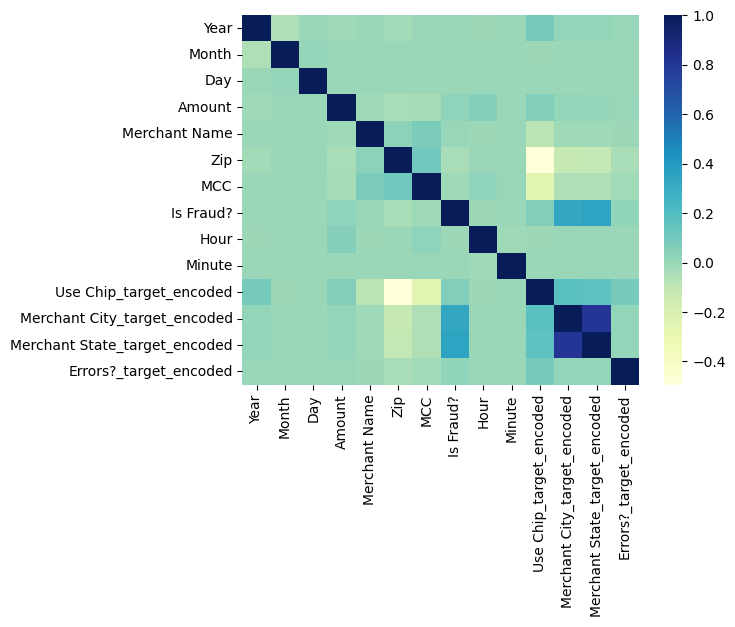

In [31]:
corr = df_transformed.corr()
dataplot = sb.heatmap(corr, cmap="YlGnBu")

### 1.5 Data Processing and Balance

1.  Apply SMOTE
2.  Scaling
3.  Split the data into data into training (80%) and testing (20%) sets

In [32]:
print(df_transformed["Is Fraud?"].value_counts())

Is Fraud?
0    2435655
1       3035
Name: count, dtype: int64


### SMOTE

In [33]:
# Apply SMOTE

X = df_transformed.drop("Is Fraud?", axis=1)
y = df_transformed["Is Fraud?"]


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Creating a new DataFrame with resampled data
resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame({"Is Fraud?": y_resampled})], axis=1)

In [34]:
print(resampled_df["Is Fraud?"].value_counts())

Is Fraud?
0    2435655
1    2435655
Name: count, dtype: int64


In [35]:
resampled_df

,Year,Month,Day,Amount,Merchant Name,Zip,MCC,Hour,Minute,Use Chip_target_encoded,Merchant City_target_encoded,Merchant State_target_encoded,Errors?_target_encoded,Is Fraud?
0,2019,7,10,59.180000,-6853385250336487424,20776.0,5813,0.0,11.0,0.000760,0.000000,0.000264,0.001216,0
1,2019,1,14,280.910000,4241336128694185472,0.0,4814,22.0,12.0,0.006962,0.006942,0.006942,0.001216,0
2,2010,3,15,-144.000000,190253443608377568,92543.0,3359,7.0,7.0,0.000437,0.000000,0.000306,0.001216,0
3,2015,9,20,6.760000,-7837310524365334528,80122.0,5300,14.0,58.0,0.000760,0.000000,0.000146,0.001216,0
4,2014,10,12,9.170000,-5023497618971072512,66030.0,5812,11.0,44.0,0.000437,0.000000,0.000107,0.001216,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871305,2008,11,14,1.823145,4872340518840476672,0.0,5732,8.336417,16.36417,0.006962,0.006942,0.006942,0.001216,1
4871306,2015,7,7,7.152582,6098563624419731456,0.0,4214,15.577668,17.779788,0.006962,0.006942,0.006942,0.001216,1
4871307,2018,6,5,32.383052,-1642303950890406400,0.0,5912,13.0,21.300806,0.000760,0.343338,0.539080,0.001216,1
4871308,2012,7,12,35.952384,6759623715800999936,0.0,5311,11.471815,55.235907,0.006962,0.006942,0.006942,0.001216,1


#### Scale

In [36]:
from sklearn.preprocessing import StandardScaler


numeric_features = resampled_df.columns[:-1]  # Exclude the target column

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to numeric features
scaler.fit(resampled_df[numeric_features])

# Transforming numeric features using the scaler
resampled_df[numeric_features] = scaler.transform(resampled_df[numeric_features])

In [37]:
resampled_df.head()

,Year,Month,Day,Amount,Merchant Name,Zip,MCC,Hour,Minute,Use Chip_target_encoded,Merchant City_target_encoded,Merchant State_target_encoded,Errors?_target_encoded,Is Fraud?
0,1.555896,0.191095,-0.684661,-0.092939,-1.385294,-0.159867,0.448213,-2.774740,-1.151107,-0.734871,-0.368646,-0.365213,-0.117239,0
1,1.555896,-1.700011,-0.192772,1.429215,0.905444,-0.803157,-0.626516,2.316700,-1.088799,1.312663,-0.321907,-0.327218,-0.117239,0
2,-0.396881,-1.069642,-0.069799,-1.487749,0.069013,2.062261,-2.191812,-1.154736,-1.400342,-0.841395,-0.368646,-0.364975,-0.117239,0
3,0.687995,0.821463,0.545063,-0.452797,-1.588446,1.677669,-0.103675,0.465268,1.777400,-0.734871,-0.368646,-0.365885,-0.117239,0
4,0.471020,1.136647,-0.438717,-0.436253,-1.007475,1.241337,0.447137,-0.229020,0.905079,-0.841395,-0.368646,-0.366107,-0.117239,0


### Train/Test split

In [38]:
from sklearn.model_selection import train_test_split

# Defining features (X) and target variable (y) from the resampled_df
X_resampled = resampled_df.drop("Is Fraud?", axis=1)
y_resampled = resampled_df["Is Fraud?"]

# Spliting the resampled data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Checking the shapes of the resulting subsets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (3897048, 13)
Testing set shape: (974262, 13)


### Logistic Regression

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import time

model = make_pipeline(StandardScaler(), LogisticRegression())


start_time = time.time()

scores = cross_val_score(model, X_train, y_train, cv=5)
end_time = time.time()
cv_time = end_time - start_time
print(f"Cross-validation scores: {scores}")
print(f"Average score: {np.mean(scores)}")
print(f"Cross-validation took {cv_time:.3f} seconds")

Cross-validation scores: [0.91551173 0.91492411 0.91470215 0.91559759 0.91532944]
Average score: 0.9152130023805245
Cross-validation took 69.848 seconds


Confusion Matrix:
[[432700  53953]
 [ 28762 458847]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91    486653
           1       0.89      0.94      0.92    487609

    accuracy                           0.92    974262
   macro avg       0.92      0.92      0.92    974262
weighted avg       0.92      0.92      0.92    974262



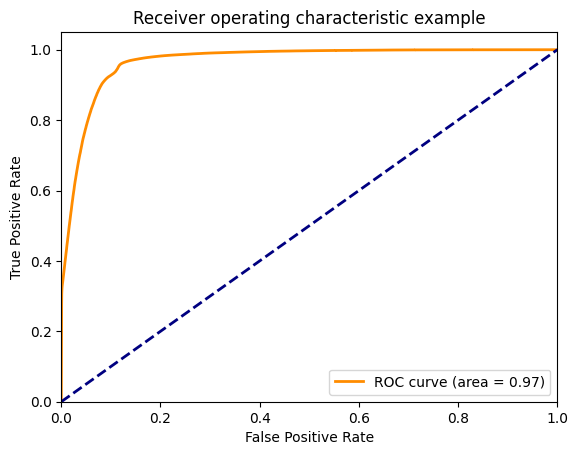


Model Coefficients:
Year: -0.6099020504351835
Month: -0.07151948381776653
Day: -0.09784380163110719
Amount: 0.45364020419274037
Merchant Name: 0.2373835329628472
Zip: 0.20560117919504395
MCC: 0.13107017684842368
Hour: -0.2862438434817903
Minute: -0.010211793168165414
Use Chip_target_encoded: 2.0485239560822923
Merchant City_target_encoded: 33.66203622326332
Merchant State_target_encoded: -17.655834214450444
Errors?_target_encoded: 0.1719957197985292


In [40]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

model.fit(X_train, y_train)

# Predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(cr)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Model Coefficients
# For pipeline, access the logistic regression model's coefficients with named_steps
coefficients = model.named_steps['logisticregression'].coef_
feature_names = X_train.columns  # Adjust if necessary to match your feature matrix
print("\nModel Coefficients:")
for name, coef in zip(feature_names, coefficients[0]):
    print(f"{name}: {coef}")


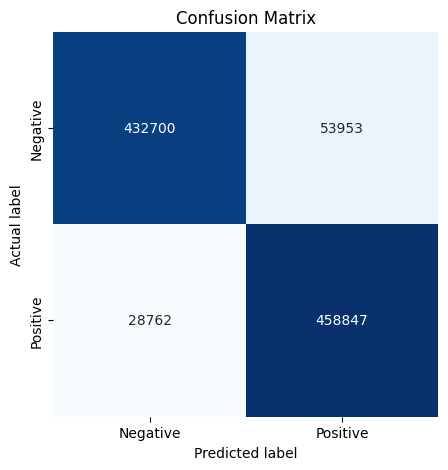

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True, cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

plt.show()


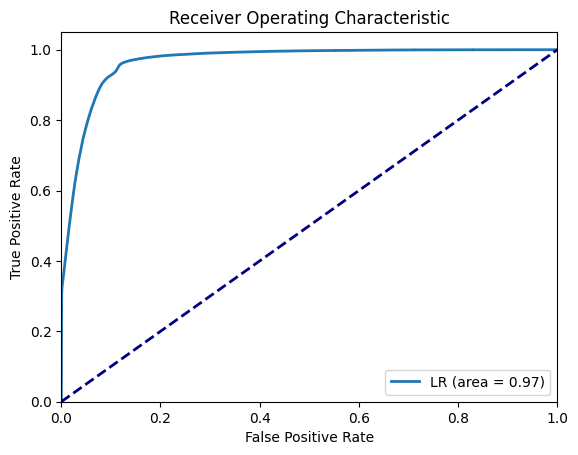

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have a logistic regression model named 'logistic_model'
# and your test data is split into features (X_test) and labels (y_test)

# Predict probabilities for the positive class (fraudulent transactions)
y_score = model.predict_proba(X_test)[:,1]

# Compute ROC curve and ROC area for the model
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, 
         lw=2, label='LR (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Naive Bayes

In [43]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

Time taken to train Gaussian Naive Bayes model: 1.2366492748260498 seconds
Model: Naive Bayes
F1-Score: 73.95%
Accuracy: 71.67%
        0       1
0  482515    4138
1  272173  215436
              precision    recall  f1-score   support

           0       0.64      0.99      0.78    486653
           1       0.98      0.44      0.61    487609

    accuracy                           0.72    974262
   macro avg       0.81      0.72      0.69    974262
weighted avg       0.81      0.72      0.69    974262



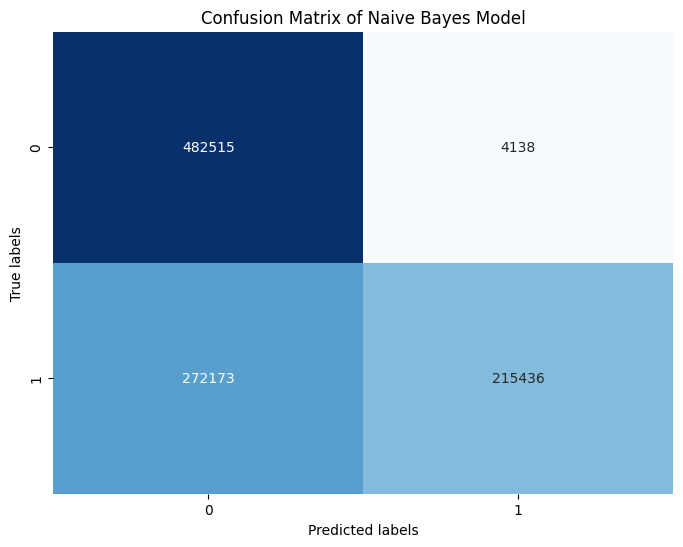

In [44]:
gnb = GaussianNB()

start_time = time.time()

gnb.fit(X_train, y_train.ravel())

end_time = time.time()

# Calculate the time taken
elapsed_time = end_time - start_time
print("Time taken to train Gaussian Naive Bayes model:", elapsed_time, "seconds")

gnb_pred = gnb.predict(X_test)

f1 = f1_score(gnb_pred, y_test, average='weighted')
accuracies = cross_val_score(estimator=gnb, X=X_train, y=y_train, cv=5, scoring="accuracy")
cv_accuracy = accuracies.mean()

print('Model: Naive Bayes')
print(f"F1-Score: {f1 * 100:.2f}%")
print(f"Accuracy: {cv_accuracy * 100:.2f}%")
    
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, gnb_pred)
print(pd.DataFrame(conf_matrix))


print(classification_report(y_test, gnb_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of Naive Bayes Model")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [45]:
y_pred_nb = gnb.predict_proba(X_test)[:,1]
nb_fpr, nb_tpr, threshold = roc_curve(y_test, y_pred_nb)
auc_nb = auc(nb_fpr, nb_tpr)

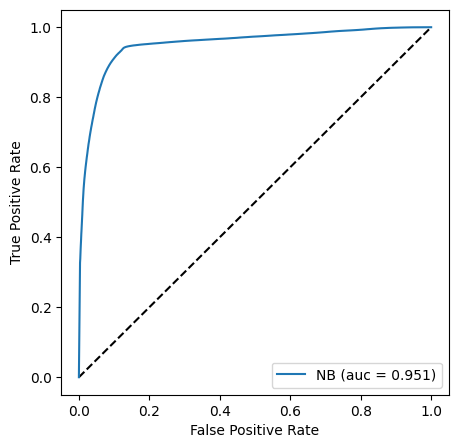

In [46]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(nb_fpr, nb_tpr, linestyle='-', label='NB (auc = %0.3f)' % auc_nb)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

plt.show()

### Neural Network

In [47]:
# After splitting the data into train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Checking the first few rows of the scaled training and testing sets
print("Scaled Training Data:")
print(X_train_scaled[:5])

print("Scaled Testing Data:")
print(X_test_scaled[:5])

Scaled Training Data:
[[-4.36414738e+02 -1.65694153e+00 -1.84735780e+00 -5.01758217e-01
   2.97312593e-02 -8.03181412e-01 -5.80495708e+00 -2.91395823e+00
  -1.74469300e+00  4.32372114e+02 -2.53607441e+00 -2.22859421e+00
  -5.58073944e+01]
 [-4.36367659e+02 -1.45825932e+00 -1.71125787e+00 -5.02590613e-01
   2.97312593e-02 -8.03153138e-01 -5.80495939e+00 -3.14909803e+00
  -1.81504962e+00 -2.43593498e+02 -2.85077139e+00 -2.44610212e+00
  -5.58073944e+01]
 [-4.36226425e+02 -2.05430594e+00 -2.11955765e+00 -5.02372887e-01
   2.97312593e-02 -8.03148596e-01 -5.80483324e+00 -3.04197918e+00
  -1.86163806e+00 -2.78760746e+02 -2.85077139e+00 -2.44712632e+00
  -5.58073944e+01]
 [-4.36461816e+02 -1.65694153e+00 -2.05906879e+00 -5.01609433e-01
   2.97312593e-02 -8.03109487e-01 -5.80532164e+00 -2.72062262e+00
  -1.87716754e+00 -2.78760746e+02 -2.85077139e+00 -2.44684741e+00
  -5.58073944e+01]
 [-4.37215067e+02 -2.05430594e+00 -1.98345772e+00 -4.98040518e-01
   2.97312593e-02 -8.03087438e-01 -5.8060149

In [48]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K  # Add this import for the Keras backend
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Defining custom metrics functions for recall and F1-score
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

2024-03-08 09:11:15.012160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 09:11:15.012268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 09:11:15.143785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [49]:
from tensorflow import keras
from keras import backend as K  # Add this import for the Keras backend
from keras.utils import plot_model

# Defining the neural network architecture
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer with the number of features
    keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons and ReLU activation
    keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 neurons and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with a single neuron and sigmoid activation
])
# Compile the model with custom metrics
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', 'Recall', 'Precision'])  # Include precision_m and recall_m

# Train the model on the training data
model.fit(X_train_scaled, y_train, epochs=10, batch_size=128, validation_split=0.2, verbose=2)


Epoch 1/10


I0000 00:00:1709889089.447496     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709889089.466218     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24357/24357 - 53s - 2ms/step - Precision: 0.8952 - Recall: 0.9479 - accuracy: 0.9185 - loss: 0.2622 - val_Precision: 0.8954 - val_Recall: 0.9613 - val_accuracy: 0.9243 - val_loss: 0.2428
Epoch 2/10
24357/24357 - 48s - 2ms/step - Precision: 0.8944 - Recall: 0.9682 - accuracy: 0.9270 - loss: 0.2193 - val_Precision: 0.8942 - val_Recall: 0.9749 - val_accuracy: 0.9296 - val_loss: 0.2083
Epoch 3/10
24357/24357 - 48s - 2ms/step - Precision: 0.8943 - Recall: 0.9719 - accuracy: 0.9286 - loss: 0.2101 - val_Precision: 0.8946 - val_Recall: 0.9771 - val_accuracy: 0.9308 - val_loss: 0.1969
Epoch 4/10
24357/24357 - 47s - 2ms/step - Precision: 0.8941 - Recall: 0.9739 - accuracy: 0.9293 - loss: 0.2061 - val_Precision: 0.8950 - val_Recall: 0.9760 - val_accuracy: 0.9306 - val_loss: 0.1993
Epoch 5/10
24357/24357 - 47s - 2ms/step - Precision: 0.8941 - Recall: 0.9748 - accuracy: 0.9297 - loss: 0.2037 - val_Precision: 0.8931 - val_Recall: 0.9807 - val_accuracy: 0.9315 - val_loss: 0.1943
Epoch 6/10
24357/2435

In [50]:
from sklearn.metrics import f1_score

# Evaluate the model on the test dataset
model.evaluate(X_test_scaled, y_test)

# Make predictions on the test dataset
y_pred = model.predict(X_test_scaled)

# round the predictions to binary values (0 or 1)
rounded_predictions = [int(round(pred[0])) for pred in y_pred]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, rounded_predictions)
precision = precision_score(y_test, rounded_predictions)
recall = recall_score(y_test, rounded_predictions)
# Calculate F1 Score using sklearn's f1_score function
f1 = f1_score(y_test, rounded_predictions)

conf_matrix = confusion_matrix(y_test, rounded_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

30446/30446 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - Precision: 0.8946 - Recall: 0.9739 - accuracy: 0.9295 - loss: 0.2032
30446/30446 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
Accuracy: 0.9294440304558733
Precision: 0.8943536132770207
Recall: 0.9740919466211657
F1 Score: 0.9325213116427732
Confusion Matrix:
[[430546  56107]
 [ 12633 474976]]


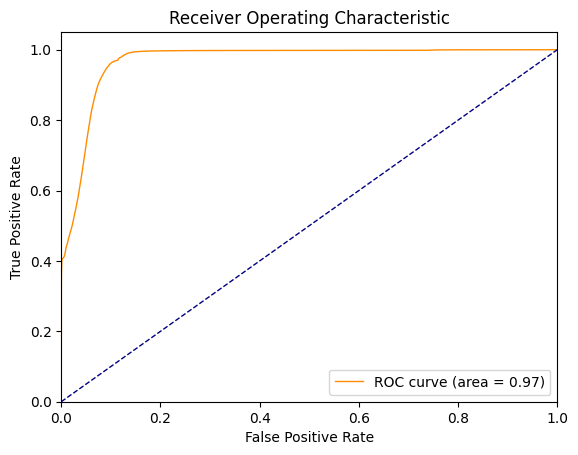

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test are the true labels and y_probs are the probabilities of positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'criterion': ['gini', 'entropy'],
            'max_features': ['auto', 'sqrt']
        }
    }}

In [ ]:
scores = []

for model_name, mp in model_params.items():
    start_time = time.time()  # Start the timer
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, verbose=3, n_jobs=-1, scoring='recall', return_train_score=False)
    clf.fit(X_train_scaled, y_train)
    end_time = time.time()  # End the timer
    duration = end_time - start_time  # Calculate the duration
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'cross_validation_time': duration  # Store the duration
    })

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params', 'cross_validation_time'])
df

In [52]:
from sklearn.ensemble import RandomForestClassifier
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100],
            'max_depth': [20],
            'criterion': ['entropy'],
            'max_features': ['sqrt']
        }
    }}

In [53]:
import time


scores = []

for model_name, mp in model_params.items():
    start_time = time.time()  # Start the timer
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, verbose=3, n_jobs=-1, scoring='recall', return_train_score=False)
    clf.fit(X_train_scaled, y_train)
    end_time = time.time()  # End the timer
    duration = end_time - start_time  # Calculate the duration
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'cross_validation_time': duration  # Store the duration
    })

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params', 'cross_validation_time'])
df

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=100;, score=1.000 total time=16.3min
[CV 3/3] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.999 total time=16.4min
[CV 2/3] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.999 total time=16.6min


,model,best_score,best_params,cross_validation_time
0,random_forest,0.999389,"{'criterion': 'entropy', 'max_depth': 20, 'max...",2270.868475


In [54]:
pd.set_option('display.max_colwidth', None)
print(df)

           model  best_score  \
0  random_forest    0.999389   

                                                                              best_params  \
0  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}   

   cross_validation_time  
0            2270.868475  


In [55]:
model_random_forest = RandomForestClassifier(criterion='gini',max_depth=20, max_features = "sqrt", random_state=42, n_estimators=100)
model_random_forest.fit(X_train_scaled, y_train)
random_forest_predictions  = model_random_forest.predict(X_test_scaled)

In [56]:
#Printing Confusion Matrix
pd.DataFrame(confusion_matrix(y_test,random_forest_predictions))
conf_mat = confusion_matrix(y_test,random_forest_predictions)

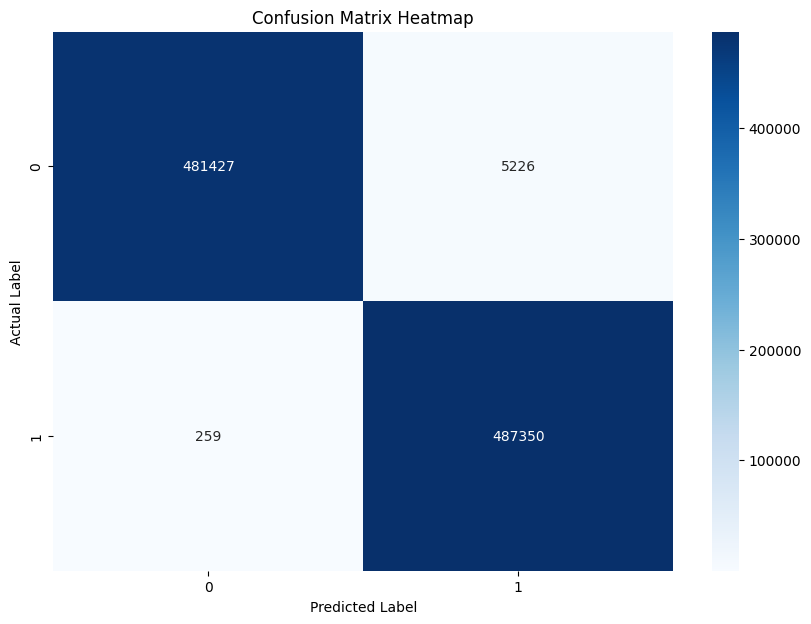

In [57]:
# Now let's create a heatmap using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.title('Confusion Matrix Heatmap')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [58]:
print(classification_report(y_test, random_forest_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    486653
           1       0.99      1.00      0.99    487609

    accuracy                           0.99    974262
   macro avg       0.99      0.99      0.99    974262
weighted avg       0.99      0.99      0.99    974262



In [59]:
from sklearn.metrics import roc_curve, auc
y_pred_random= model_random_forest.predict_proba(X_test_scaled)[:,1]
random_fpr, random_tpr, threshold = roc_curve(y_test, y_pred_random)
auc_random = auc(random_fpr, random_tpr)

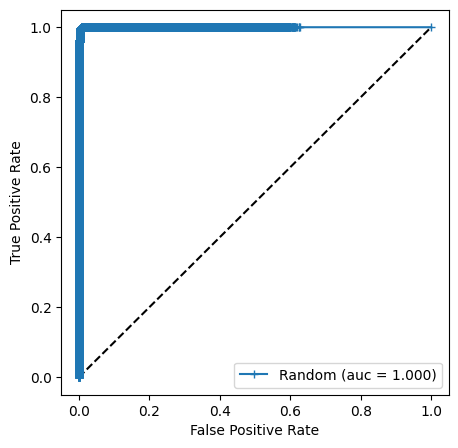

In [60]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot([0, 1], [0, 1], 'k--')


plt.plot(random_fpr, random_tpr, marker='+', label='Random (auc = %0.3f)' % auc_random)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='best')